# Session Length vs. Data Transfer -- Anomaly Detection with Python

## This notebook demonstrates use of the Python Outlier Detection (PyOD) module to detect anomalies in users session lengths (in seconds) and data transferred (in MB). 

## See  pypi.org  for more information on PyOD

https://pypi.org/project/pyod/

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline

# Anomaly detection models
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN

In [2]:
# read the cyber data
df = pd.read_excel("cyberdata.xlsx")

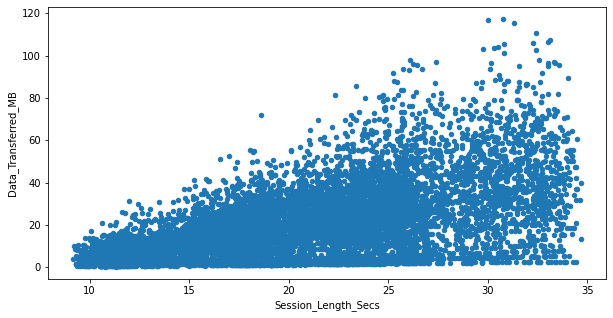

In [3]:
# Create a scatter plot of Session_Length_Secs vs. Data_Transferred_MB
df.plot.scatter( 'Session_Length_Secs', 'Data_Transferred_MB', figsize=(10,5) )

In [4]:
# Scale down the data to aid in visualization creation.
scaler = MinMaxScaler( feature_range=(0, 1) )
df[ ['Session_Length_Secs', 'Data_Transferred_MB'] ] = \
    scaler.fit_transform(df[ ['Session_Length_Secs', 'Data_Transferred_MB'] ])

In [5]:
# Save the values for later usage in calls to classifier fit().
X1 = df['Session_Length_Secs'].values.reshape(-1,1)
X2 = df['Data_Transferred_MB'].values.reshape(-1,1)
X = np.concatenate( (X1, X2), axis=1 )

In [6]:
rand_value = 3  #  for randomization
random_state = np.random.RandomState( rand_value )

# Set the desired outlier detection fraction (i.e., % observations dissimilar to the other data):
outlier_fraction = 0.03

# The dictionary of outlier detection models
classifiers = {
        'K Nearest Neighbors (KNN)': KNN(contamination=outlier_fraction),
        'Isolation Forest': IForest(contamination=outlier_fraction, random_state=random_state),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outlier_fraction, check_estimator = False, random_state = random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outlier_fraction)
}


 NOTE: This cell may take a while to finish (depending on your hardware).


K Nearest Neighbors (KNN) --> # Outliers detected: 192,  # Inliers: 8331 


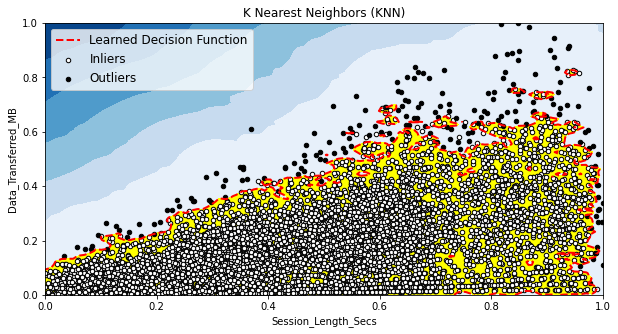



Isolation Forest --> # Outliers detected: 256,  # Inliers: 8267 


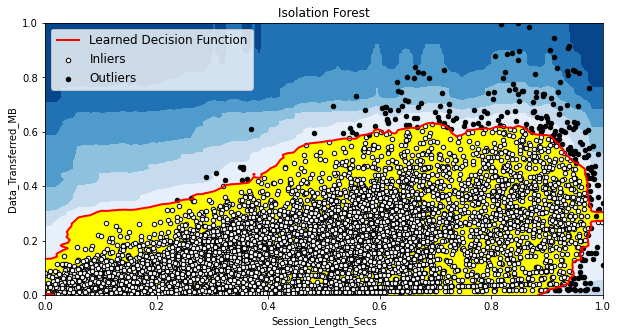



Cluster-based Local Outlier Factor (CBLOF) --> # Outliers detected: 256,  # Inliers: 8267 


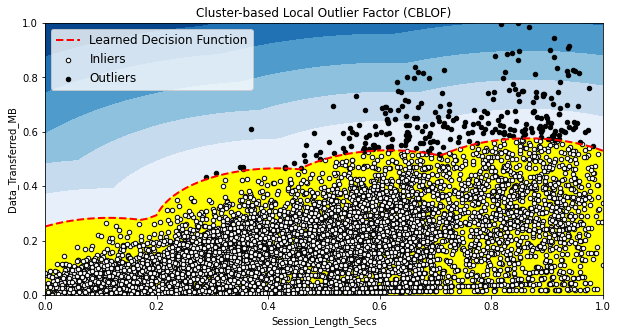



Histogram-base Outlier Detection (HBOS) --> # Outliers detected: 256,  # Inliers: 8267 


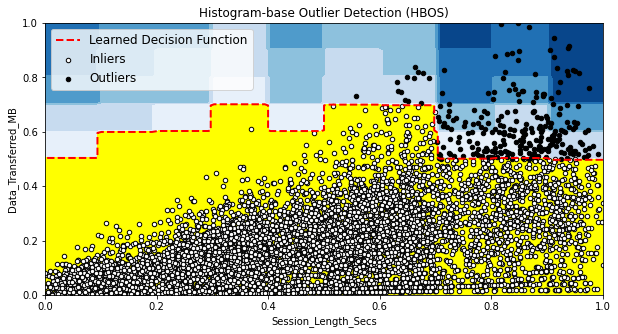

In [7]:
# Run the anomaly detection models and compare results.
# 1. Fit the data to each model to see how each model predicts the outliers
# 2. Plot the results for each model
xx, yy = np.meshgrid( np.linspace(0,1 , 100), np.linspace(0, 1, 100) )
comp_results = pd.DataFrame(columns=['model', 'outliers', 'inliers', 'ratio: out/in'] )

print("\n NOTE: This cell may take a while to finish (depending on your hardware).")

for i, (clf_name, clf) in enumerate(classifiers.items()):
    # fit the data and tag outliers
    clf.fit(X)
    
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 5))
    
    xtitle = 'Session_Length_Secs'
    ytitle = 'Data_Transferred_MB'
    
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # InX1: inlier feature #1,  InX2: inlier feature 2
    InX1 =  np.array(dfx[ xtitle ][dfx['outlier'] == 0]).reshape(-1,1)
    InX2 =  np.array(dfx[ ytitle ][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OutX1: outlier feature #1, OutX2: outlier feature 2
    OutX1 = dfx[ xtitle ][dfx['outlier'] == 1].values.reshape(-1,1)
    OutX2 = dfx[ ytitle ][dfx['outlier'] == 1].values.reshape(-1,1)

    print('\n\n{} --> # Outliers detected: {},  # Inliers: {} '.format(clf_name, n_outliers, n_inliers) )
    comp_results = comp_results.append( {'model': clf_name, 
                                         'outliers': n_outliers, 
                                         'inliers': n_inliers,
                                         'ratio: out/in': (n_outliers/n_inliers) }, ignore_index=True )
    
    threshold = stats.scoreatpercentile(scores_pred, 100 * outlier_fraction)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # color the map and contour lines
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='yellow')
        
    b = plt.scatter(InX1, InX2, c='white',s=20, edgecolor='k')
    c = plt.scatter(OutX1, OutX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    plt.legend(
        [a.collections[0], b, c],
        ['Learned Decision Function', 'Inliers','Outliers'],
        prop=matplotlib.font_manager.FontProperties(size = 12), loc="upper left")
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.xlabel( xtitle )
    plt.ylabel( ytitle )
    plt.title(clf_name)
    plt.show()

In [8]:
print("\n Summary of model comparision results:")
comp_results


 Summary of model comparision results:


,model,outliers,inliers,ratio: out/in
0,K Nearest Neighbors (KNN),192,8331,0.023046
1,Isolation Forest,256,8267,0.030966
2,Cluster-based Local Outlier Factor (CBLOF),256,8267,0.030966
3,Histogram-base Outlier Detection (HBOS),256,8267,0.030966
